<a href="https://colab.research.google.com/github/Jaquelinedops/CICIoT2023/blob/main/IoT_Traffic_Application_Attack_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# IoT application attack predict model

Autora: Jaqueline Duarte

The predict model at https://github.com/Jaquelinedops/CICIoT2023/blob/main/IoTTraffic_DecisionTreeClassifier.ipynb underperformed on the web application attacks

The aim of this study is to find the model with the best perfomance of recall; THis metric is the most appropriate because for an attack detection system, the application is desirable to find all relevant items, even if this means including some irrelevant ones. Since the impact of a false negative can have a much higher cost, becoming an undetected incident, than the cost of a false positive.

In [2]:
pip install parquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.0/779.0 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.1 MB/s eta 0:00:00
  Created wheel for thriftpy2: filename=thriftpy2-0.5.0-cp310-cp310-linux_x86_64.whl size=1747862 sha256=d98dd8ba2a62582f9746780744d3ea00998af7e461125a0c8b00a2430f3f4c61
  Stored in directory: /root/.cache/pip/wheels/05/ac/1c/efe61b4807a4964988e4cc121f4628f1af455a347914925099
Successfully built thriftpy2


In [3]:
# Importando classes e funções para modelos de classificação
from sklearn.tree import DecisionTreeClassifier
# Importando métricas de avaliação do modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier


# Importando classes e funções para divisão de dados e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.naive_bayes import GaussianNB # Import the GaussianNB class
# Importando bibliotecas de uso geral
import numpy as np
import pandas as pd

# Importando bibliotecas de visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score

# Importando biblioteca para salvar e carregar modelos treinados
import joblib
from sklearn.metrics import confusion_matrix
# Importando a biblioteca de deep learning do TensorFlow
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt

import pandas
import numpy
import seaborn
import warnings
import gc
warnings.filterwarnings('ignore')
import os
import parquet
import time




In [4]:
#importação do dataset, ajuste de tipagem de dados para melhor uso de memória
#Análise Exploratória dos dados disponível em https://github.com/Jaquelinedops/CICIoT2023/blob/main/Analise%20de%20CICIoT23(1).ipynb

def read_dataset(path= "/content/drive/MyDrive/lab/CICIoT2023/",filename = "data.parquet", bool_col_list=[],int_col_list=[]):
  df = pandas.read_parquet(path + filename, engine='pyarrow', memory_map=True)
  gc.collect()
  df[bool_col_list] = df[bool_col_list].astype('int8')
  df[int_col_list] = df[int_col_list].astype('int32')
  gc.collect()
  return df

def generate_train_test_split(df, X_columns = [], test_size=0.2, random_state=10):
  X = df[X_columns]
  Y = df['label']
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=random_state, test_size=test_size)
  gc.collect()
  return X_train, X_test, Y_train, Y_test

def barh_plot(df, column_name = "label",lenght = 10, width = 10):
  labels = df[column_name].value_counts().index.to_list()
  composition = df[column_name].value_counts(normalize=True) * 100
  fig, ax = plt.subplots(figsize=(lenght, width))
  ax.barh(labels, composition, color='blue')
  ax.set_xlabel('Percentage', fontsize=16)
  ax.tick_params(labelsize=14)
  ax.set_ylabel('Label', fontsize=16)
  ax.set_title('Data Composition - Percentage of labeled data by class', fontsize=16)
  plt.show()

def calc_metrics(model_name = "model",y_true =[], y_pred=[], start_time=0, end_time=0, average = "weighted"):
  accuracy_clf = accuracy_score(Y_test, y_pred)
  recall = recall_score(Y_test, y_pred, average = average)
  f1 = f1_score(Y_test, y_pred, average = average)
  precision = precision_score(Y_test, y_pred,  average = average)

  results  = { 'model_name': model_name,
             'start_time': start_time,
             'end_time': end_time,
             'accuracy': accuracy_clf,
             'recall': recall,
             'precision':precision,
             'f1-score': f1}
  return results

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  plt.figure(figsize=(25, 25))
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')



#Importação do parquet - gerado em EDA_CICIoT23.ipynb

The variables were selected as independent, dependent - calculated, boolean, integer as identified in EDA.py



In [5]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       ]

#dependent variables /calculated
X_columns_calc = ['Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight',]

int_col_list = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
bool_col_list = ['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']


reading parquet dataset

``````


In [6]:
path= "/content/drive/MyDrive/lab/CICIoT2023/"
filename = "data.parquet"
df = read_dataset(bool_col_list=bool_col_list,int_col_list=int_col_list)

Data composition from CICIot2023

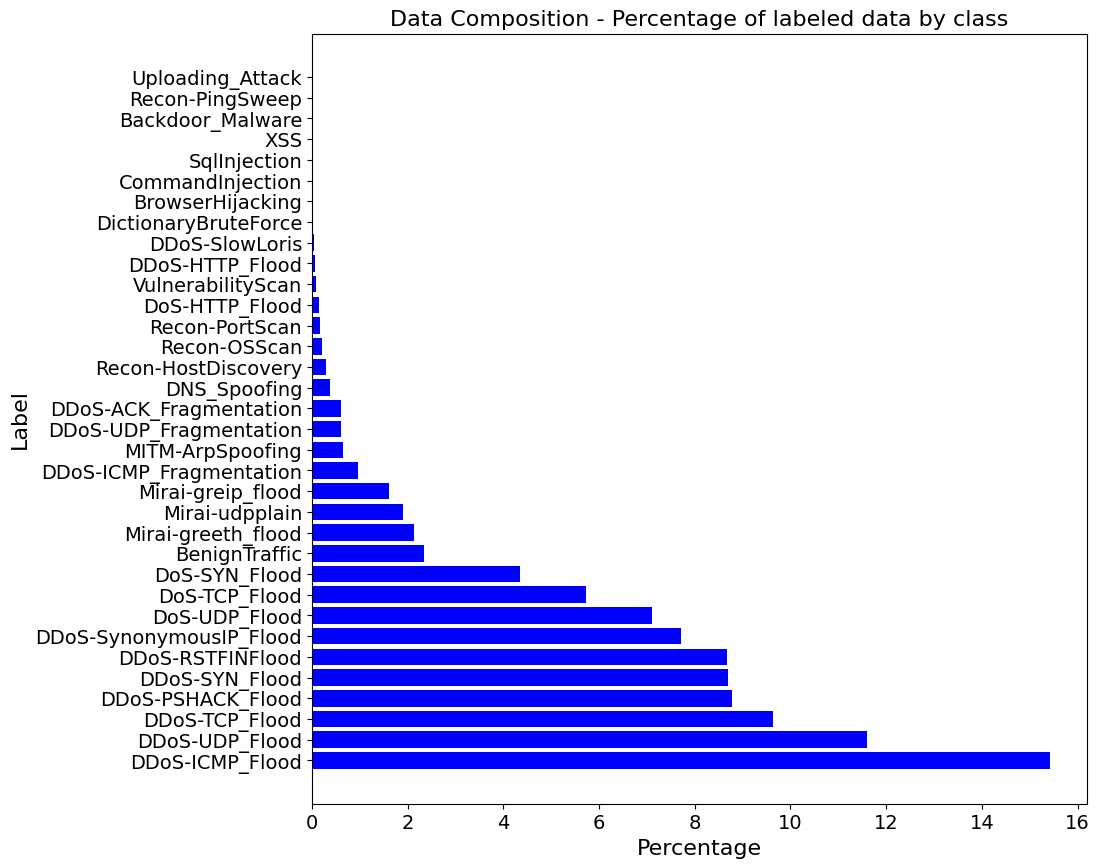

In [ ]:
#Distribuição dos dados
barh_plot(df, column_name = "label")

This study select only benign and web application attacks to train and predict     
    'BrowserHijacking','Backdoor_Malware','XSS','Uploading_Attack',   'SqlInjection','CommandInjection'



In [7]:
group_by_label = {
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DoS-UDP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-greip_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    'Recon-PingSweep': 'Recon',
    'Recon-OSScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon',
    'Recon-HostDiscovery': 'Recon',
    'DNS_Spoofing': 'Spoofing',
    'MITM-ArpSpoofing': 'Spoofing',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Application',
    'Backdoor_Malware': 'Application',
    'XSS': 'Application',
    'Uploading_Attack': 'Application',
    'SqlInjection': 'Application',
    'CommandInjection': 'Application',
    'DictionaryBruteForce': 'Bruteforce'
}

In [8]:
df['label'] = df['label'].apply(lambda x : group_by_label[x])

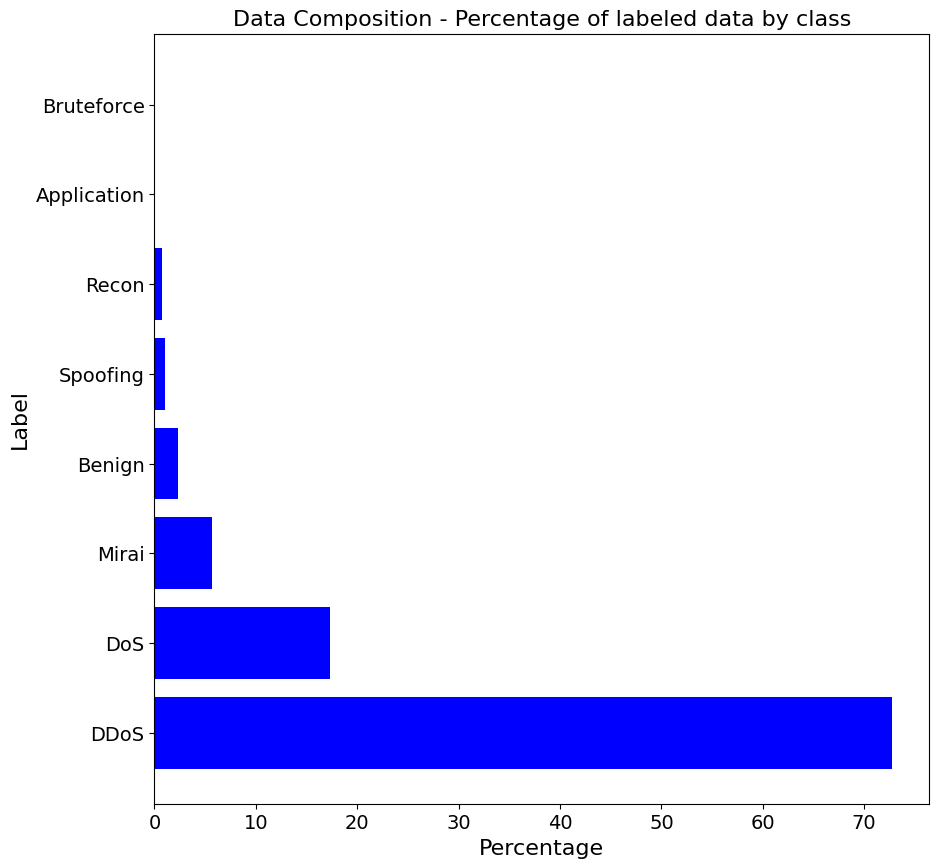

In [9]:
#Distribuição dos dados
barh_plot(df, column_name = "label")

In [9]:
df_group = pd.concat([df[df['label'] == 'Application'], df[df['label'] == 'Benign']], axis=0)
df_group['label'] = df_group['label'].apply(lambda x: 1 if x == 'Application' else 0)
X_train, X_test, Y_train, Y_test = generate_train_test_split(df_group, X_columns, test_size=0.2, random_state=10)
gc.collect()

0

Distribuição dos dados


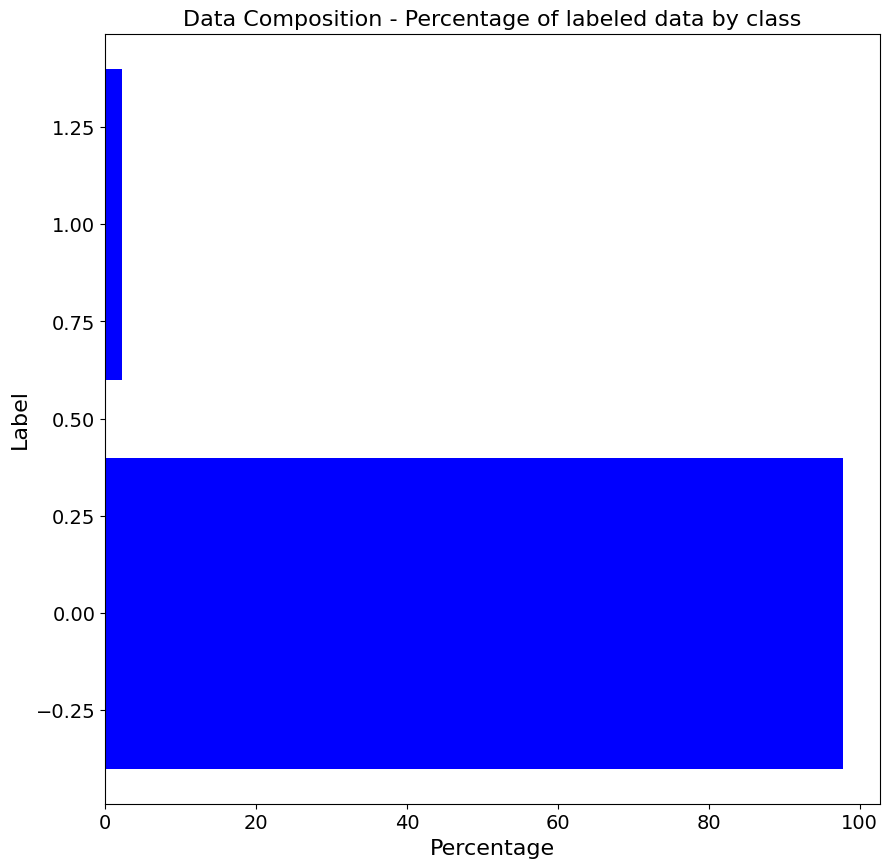

In [11]:
#Distribuição dos dados
barh_plot(df_group, column_name = "label")

# Predicting models

#Predição sobre labels categorizados por tipo de ataque

# Decision Tree não balanceado

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(X_train, Y_train)
start = time.time()
y_pred = DT.predict(X_test)
end = time.time()
time_elapsed = end - start
results = calc_metrics(model_name = "Decision_tree_unbalanced",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end)
report =classification_report(Y_test, y_pred)

In [ ]:
results

{'model_name': 'Decision_tree_unbalanced',
 'start_time': 1719082284.5537653,
 'end_time': 1719082295.5432324,
 'accuracy': 0.9804456712895973,
 'recall': 0.9804456712895973,
 'precision': 0.9807474488120455,
 'f1-score': 0.9805933097598084}

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    219512
           1       0.57      0.58      0.58      5093

    accuracy                           0.98    224605
   macro avg       0.78      0.79      0.78    224605
weighted avg       0.98      0.98      0.98    224605



As we have an unbalanced dataset here we applied weights to the data for training

In [ ]:
# Calcular a distribuição de classes no conjunto de treino
class_distribution = Y_train.value_counts(normalize=True)
# Definir o peso para cada classe com base na sua distribuição
class_weights = {cls: 1 / proportion for cls, proportion in class_distribution.items()} # Create a dictionary mapping class labels to weights


In [ ]:
DT = DecisionTreeClassifier(class_weight=class_weights)
DT.fit(X_train, Y_train)
start = time.time()
y_pred = DT.predict(X_test)
end = time.time()
time_elapsed = end - start
results = calc_metrics(model_name = "Decision_tree_balanced",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end,average="weighted")
report =classification_report(Y_test, y_pred)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    219512
           1       0.59      0.55      0.57      5093

    accuracy                           0.98    224605
   macro avg       0.79      0.77      0.78    224605
weighted avg       0.98      0.98      0.98    224605



In [ ]:
results

{'model_name': 'Decision_tree_balanced',
 'start_time': 1719082319.4111845,
 'end_time': 1719082331.7172685,
 'accuracy': 0.9811179626455333,
 'recall': 0.9811179626455333,
 'precision': 0.9804235991162421,
 'f1-score': 0.9807494937890129}

RandomForest não balanceado

In [ ]:

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train)
start = time.time()
y_pred_rfc = rfc.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "RandomForest",y_true =Y_test, y_pred=y_pred_rfc, start_time=start, end_time=end,average="macro")
report =classification_report(Y_test, y_pred_rfc)


In [ ]:
results

{'model_name': 'RandomForest',
 'start_time': 1719082319.4111845,
 'end_time': 1719082331.7172685,
 'accuracy': 0.9867411678279646,
 'recall': 0.7421605608261861,
 'precision': 0.9306054248968079,
 'f1-score': 0.8088104024138348}

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    219512
           1       0.87      0.49      0.62      5093

    accuracy                           0.99    224605
   macro avg       0.93      0.74      0.81    224605
weighted avg       0.99      0.99      0.98    224605



RandomForest balanceado



In [ ]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_estimators=100, class_weight=class_weights)
rfc.fit(X_train, Y_train)
start = time.time()
y_pred_rfc = rfc.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "RandomForest",y_true =Y_test, y_pred=y_pred_rfc, start_time=start, end_time=end,average="macro")
report =classification_report(Y_test, y_pred_rfc)

In [ ]:
results

{'model_name': 'RandomForest',
 'start_time': 1719077564.3568962,
 'end_time': 1719077577.789387,
 'accuracy': 0.986416152801585,
 'recall': 0.7303908445806787,
 'precision': 0.9353147568947215,
 'f1-score': 0.799933962399008}

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    219512
           1       0.88      0.46      0.61      5093

    accuracy                           0.99    224605
   macro avg       0.94      0.73      0.80    224605
weighted avg       0.99      0.99      0.98    224605



In [19]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, Y_train)
start = time.time()
y_pred_nb = nb.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "GaussianNB_unbalanced",y_true =Y_test, y_pred=y_pred_nb, start_time=start, end_time=end,average="macro")
report =classification_report(Y_test, y_pred_nb)

In [20]:
results

{'model_name': 'GaussianNB_unbalanced',
 'start_time': 1719103560.8162804,
 'end_time': 1719103560.9244378,
 'accuracy': 0.9720709690345273,
 'recall': 0.6653223350108693,
 'precision': 0.6794237318919867,
 'f1-score': 0.6720584655441793}

In [21]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    219512
           1       0.37      0.34      0.36      5093

    accuracy                           0.97    224605
   macro avg       0.68      0.67      0.67    224605
weighted avg       0.97      0.97      0.97    224605



In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    219512
           1       0.87      0.49      0.62      5093

    accuracy                           0.99    224605
   macro avg       0.93      0.74      0.81    224605
weighted avg       0.99      0.99      0.98    224605



Balancing the dataset didn't improve the model recall result, so here we apply oversampling augmentation methodology, particularly using the SMOTE (Synthetic Minority Oversampling Technique) algorithm to the train dataset

In [10]:
from imblearn.over_sampling import SMOTE
X = X_train
y = Y_train

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['label'] = y_resampled

resampled_df.value_counts('label')
gc.collect()

0

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rfc_sampled = RandomForestClassifier(n_estimators=100)
rfc_sampled.fit(X_resampled, y_resampled)
start = time.time()
y_pred_rfc = rfc_sampled.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "RandomForest_sampled",y_true =Y_test, y_pred=y_pred_rfc, start_time=start, end_time=end,average="macro")
report =classification_report(Y_test, y_pred_rfc)


In [ ]:
results

{'model_name': 'RandomForest_sampled',
 'start_time': 1719084224.1698785,
 'end_time': 1719084228.7129123,
 'accuracy': 0.9654504574697803,
 'recall': 0.885756970979384,
 'precision': 0.6861306434493548,
 'f1-score': 0.7475099865114934}

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    219512
           1       0.38      0.80      0.51      5093

    accuracy                           0.97    224605
   macro avg       0.69      0.89      0.75    224605
weighted avg       0.98      0.97      0.97    224605



In [ ]:
dtc_sampled = DecisionTreeClassifier()
dtc_sampled.fit(X_resampled, y_resampled)
start = time.time()
y_pred_dtc = dtc_sampled.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "DecisionTreeClassifier_Sampled",y_true =Y_test, y_pred=y_pred_dtc, start_time=start, end_time=end,average="macro")
report =classification_report(Y_test, y_pred_dtc)

In [ ]:
results

{'model_name': 'DecisionTreeClassifier_Sampled',
 'start_time': 1719084265.0566924,
 'end_time': 1719084265.1068256,
 'accuracy': 0.9650185881881526,
 'recall': 0.8496708533496793,
 'precision': 0.678954747644254,
 'f1-score': 0.7338627151344307}

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    219512
           1       0.36      0.73      0.49      5093

    accuracy                           0.97    224605
   macro avg       0.68      0.85      0.73    224605
weighted avg       0.98      0.97      0.97    224605



In [22]:
nb_oversampled = GaussianNB()
nb_oversampled.fit(X_resampled, y_resampled)
start = time.time()
y_pred_nb_os = nb_oversampled.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "GaussianNB_oversampled",y_true =Y_test, y_pred=y_pred_nb_os, start_time=start, end_time=end,average="macro")
report =classification_report(Y_test, y_pred_nb_os)

In [23]:
results

{'model_name': 'GaussianNB_oversampled',
 'start_time': 1719103589.6443243,
 'end_time': 1719103589.7525196,
 'accuracy': 0.5887402328532312,
 'recall': 0.7333081415866423,
 'precision': 0.5211107285854029,
 'f1-score': 0.41166235726297795}

In [24]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.58      0.73    219512
           1       0.05      0.88      0.09      5093

    accuracy                           0.59    224605
   macro avg       0.52      0.73      0.41    224605
weighted avg       0.97      0.59      0.72    224605



RandomizedSearchCV is a scikit-learn library for hyperparameter optimization in machine learning models. It explores a vast range of hyperparameter combinations to identify the set that yields the best performance for a given dataset and model.

In [ ]:


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
random_search = RandomizedSearchCV(rfc, param_grid, cv=5, n_iter=10)
random_search.fit(X_resampled, y_resampled)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print("Best parameters:", best_params)
print("Best model:", best_model)


Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini'}
Best model: RandomForestClassifier(max_depth=20, min_samples_split=10)


Applying the best model from RandomizedSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier

rfc_tunned = RandomForestClassifier(min_samples_split=10, min_samples_leaf=1, max_depth=20, criterion='gini')  # Create a random forest classifier with 100 trees
rfc_tunned.fit(X_resampled, y_resampled)
start = time.time()
y_pred_rfc = rfc_tunned.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "RandomForest_ressampled_tunned",y_true =Y_test, y_pred=y_pred_rfc, start_time=start, end_time=end,average="weighted")
report =classification_report(Y_test, y_pred_rfc)

In [ ]:
print(report)
results


              precision    recall  f1-score   support

           0       1.00      0.95      0.97    219512
           1       0.28      0.86      0.42      5093

    accuracy                           0.95    224605
   macro avg       0.64      0.90      0.70    224605
weighted avg       0.98      0.95      0.96    224605



{'model_name': 'RandomForest',
 'start_time': 1719077564.3568962,
 'end_time': 1719077577.789387,
 'accuracy': 0.9463547116048173,
 'recall': 0.9463547116048173,
 'precision': 0.9803347168407932,
 'f1-score': 0.9593882261131792}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search = RandomizedSearchCV(dtc_sampled, param_grid, cv=5, n_iter=10)
random_search.fit(X_resampled,y_resampled)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print("Best parameters:", best_params)
print("Best model:", best_model)


Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}
Best model: DecisionTreeClassifier(min_samples_split=5)


In [ ]:
dtc_sampled_tunned = DecisionTreeClassifier(min_samples_split=5,min_samples_leaf=1,max_depth=None, criterion="gini")
dtc_sampled_tunned.fit(X_resampled, y_resampled)
start = time.time()
y_pred_dtc = dtc_sampled_tunned.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "DecisionTreeClassifier_Sampled_tunned",y_true =Y_test, y_pred=y_pred_dtc, start_time=start, end_time=end,average="macro")
report =classification_report(Y_test, y_pred_dtc)

In [ ]:
results

{'model_name': 'DecisionTreeClassifier_Sampled_tunned',
 'start_time': 1719086438.644268,
 'end_time': 1719086438.6923745,
 'accuracy': 0.9657799247567953,
 'recall': 0.8448819597349426,
 'precision': 0.6812377404004191,
 'f1-score': 0.7349835584970128}

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    219512
           1       0.37      0.72      0.49      5093

    accuracy                           0.97    224605
   macro avg       0.68      0.84      0.73    224605
weighted avg       0.98      0.97      0.97    224605



In [27]:
# prompt: APPLY RANDOMIZED SEARCH TO GAUSSIANNB

import numpy as np
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

random_search = RandomizedSearchCV(nb_oversampled, param_grid, cv=5, n_iter=10)
random_search.fit(X_resampled,y_resampled)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print("Best parameters:", best_params)
print("Best model:", best_model)


Best parameters: {'var_smoothing': 1e-09}
Best model: GaussianNB()


In [28]:
nb_oversampled_tunned = GaussianNB(var_smoothing= 1e-09)
nb_oversampled_tunned.fit(X_resampled, y_resampled)
start = time.time()
y_pred_nb_os = nb_oversampled_tunned.predict(X_test)
end = time.time()
results = calc_metrics(model_name = "GaussianNB_oversampled_tunned",y_true =Y_test, y_pred=y_pred_nb_os, start_time=start, end_time=end,average="macro")
report =classification_report(Y_test, y_pred_nb_os)

In [29]:
results

{'model_name': 'GaussianNB_oversampled_tunned',
 'start_time': 1719103879.4347243,
 'end_time': 1719103879.5161595,
 'accuracy': 0.5887402328532312,
 'recall': 0.7333081415866423,
 'precision': 0.5211107285854029,
 'f1-score': 0.41166235726297795}

In [30]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.58      0.73    219512
           1       0.05      0.88      0.09      5093

    accuracy                           0.59    224605
   macro avg       0.52      0.73      0.41    224605
weighted avg       0.97      0.59      0.72    224605



# Feature Selection

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
X = df_group[X_columns]
Y = df_group['label']
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X,Y)
selected_features = selector.get_support(indices=True)
X_new = df_group.columns[selected_features]

In [12]:
X_train, X_test, Y_train, Y_test = generate_train_test_split(df_group, X_new, test_size=0.3, random_state=10)
gc.collect()

0

In [13]:
from imblearn.over_sampling import SMOTE
X = X_train
y = Y_train

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

resampled_df = pd.DataFrame(X_resampled, columns=X_columns)
resampled_df['label'] = y_resampled

resampled_df.value_counts('label')
gc.collect()

0

In [15]:
from sklearn.ensemble import RandomForestClassifier


rfc_featured= RandomForestClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=None, criterion='entropy')  # Create a random forest classifier with 100 trees
rfc_featured.fit(X_resampled, y_resampled)
start_time = start = time.time()
y_pred_rfc = rfc_featured.predict(X_test)
end_time = time.time()
results = calc_metrics(model_name = "RandomForest_featured",y_true =Y_test, y_pred=y_pred_rfc, start_time=start_time, end_time=end_time,average="macro")
report =classification_report(Y_test, y_pred_rfc,digits=5)

In [16]:
print(report)

              precision    recall  f1-score   support

           0    0.99507   0.97098   0.98288    329289
           1    0.38708   0.79210   0.52003      7619

    accuracy                        0.96693    336908
   macro avg    0.69108   0.88154   0.75146    336908
weighted avg    0.98132   0.96693   0.97241    336908



In [17]:
results

{'model_name': 'RandomForest_featured',
 'start_time': 1719105368.902176,
 'end_time': 1719105374.4353006,
 'accuracy': 0.9669345934201622,
 'recall': 0.8815392998664264,
 'precision': 0.6910762899539205,
 'f1-score': 0.7514559848999983}